# Evaluations For Multi-Class Classification Models

This workflow, part of our [MLOps](../readme.md) series that dives into [Model Evaluation](./readme.md), provides a comprehensive, end-to-end example of building and evaluating a machine learning model directly within Google Cloud's Vertex AI ecosystem.

Specifically, this guide will walk you through how to:

* **Prepare Data at Scale:** Begin by exploring and efficiently preparing a large public dataset sourced from **BigQuery**, demonstrating how to leverage both powerful **SQL** queries and the interactive **BigFrames API** (pandas interface) for machine learning data readiness.
* **Build Robust Models with Scikit-learn:** Construct a complete **Scikit-learn model pipeline** that seamlessly integrates additional feature engineering steps with the training of a classification model.
* **Register Models in Vertex AI:** Master the crucial MLOps step of saving your trained model and **registering it as a version within the Vertex AI Model Registry** for centralized management and version control.
* **Generate & Upload Custom Metrics:** Delve into preparing **custom, detailed evaluation metrics** using **Scikit-learn**, and then strategically **load these results to your versioned model in the Vertex AI Model Registry**. This includes showcasing how to generate and upload metrics for specific **data slices** to gain granular performance insights.
* **Review & Retrieve Evaluations:** Conclude by learning how to easily **review and programmatically retrieve these comprehensive evaluation results** directly from the Model Registry UI and via the **Vertex AI SDK**, empowering you to effectively track and compare model performance over time.


---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('bigframes', 'bigframes'),
    ('sklearn', 'scikit-learn'),
    ('numpy', 'numpy'),
    ('shap', 'shap'),
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'), 
    ('google.cloud.storage', 'google-cloud-storage'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('bigquery_magics', 'bigquery-magics'),
    ('matplotlib', 'matplotlib'),
    ('pandas', 'pandas')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
SERIES = 'mlops'
EXPERIMENT = 'evaluation-classification-multi-class'

# Set the name of GCS Bucket to read/write to
GCS_BUCKET = PROJECT_ID

# Data source for this workflow
BQ_SOURCE = 'bigquery-public-data.ml_datasets.penguins'

# make this the BigQuery Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2] # use a multi region

packages:

In [8]:
import os
import joblib
import sklearn.metrics
import sklearn.ensemble
import sklearn.pipeline
import sklearn.compose
import sklearn.preprocessing
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bigframes.pandas as bpd
from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage

clients:

In [9]:
# vertex ai clients
aiplatform.init(project = PROJECT_ID, location = REGION, experiment = SERIES+'-'+EXPERIMENT)

# gcs storage client
gcs = storage.Client(project = GCS_BUCKET)
bucket = gcs.bucket(GCS_BUCKET)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# bigframes setup
bpd.options.bigquery.project = PROJECT_ID

# bigquery cell magics load
%load_ext bigquery_magics

Parameters:

In [10]:
DIR = f"files/{EXPERIMENT}"

Environment:

In [11]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Review Data Source: Palmer Penguins

This project will uses the following data source as a tutorial.  It is good for examples like this because it is small, has few columns, but contains categorial and numerical data types.

The source table is a BigQuery Public Dataset table.  The following cell uses the [BigQuery IPython magic](https://cloud.google.com/python/docs/reference/bigquery/latest/magics) to retrieve 5 rows of the table for review.  This data is known as [Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/) data: 

```
@Manual{,
  title = {palmerpenguins: Palmer Archipelago (Antarctica) penguin data},
  author = {Allison Marie Horst and Alison Presmanes Hill and Kristen B Gorman},
  year = {2020},
  note = {R package version 0.1.0},
  doi = {10.5281/zenodo.3960218},
  url = {https://allisonhorst.github.io/palmerpenguins/},
}
```


There are 334 observations of 4 numerical features (culman length, culmen depth, flipper length, body mass) and 2  categorical features (island, sex) that represent 3 species of penguins.

### Review BigQuery table:

Use the [BigQuery BigFrames](https://cloud.google.com/bigquery/docs/use-bigquery-dataframes) package, setup above, to treat BigQuery tables like dataframes.  This has the advantage of doing the computing within BigQuery rather than pulling the data locally.

In [12]:
source_data = bpd.read_gbq(BQ_SOURCE)
source_data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Gentoo penguin (Pygoscelis papua),Biscoe,45.2,16.4,223.0,5950.0,MALE
1,Gentoo penguin (Pygoscelis papua),Biscoe,46.5,14.5,213.0,4400.0,FEMALE
2,Adelie Penguin (Pygoscelis adeliae),Biscoe,37.7,16.0,183.0,3075.0,FEMALE
3,Gentoo penguin (Pygoscelis papua),Biscoe,46.4,15.6,221.0,5000.0,MALE
4,Gentoo penguin (Pygoscelis papua),Biscoe,46.1,13.2,211.0,4500.0,FEMALE


In [13]:
source_data.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 344 entries, 0 to 343
Data columns (total 7 columns):
  #  Column             Non-Null Count    Dtype
---  -----------------  ----------------  -------
  0  species            344 non-null      string
  1  island             344 non-null      string
  2  culmen_length_mm   342 non-null      Float64
  3  culmen_depth_mm    342 non-null      Float64
  4  flipper_length_mm  342 non-null      Float64
  5  body_mass_g        342 non-null      Float64
  6  sex                334 non-null      string
dtypes: Float64(4), string(3)
memory usage: 22016 bytes


In [14]:
source_data.describe(include = 'all')

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.0,342.0,342.0,342.0,334
nunique,3,3,<NA>,<NA>,<NA>,<NA>,3
mean,<NA>,<NA>,43.92193,17.15117,200.915205,4201.754386,<NA>
std,<NA>,<NA>,5.459584,1.974793,14.061714,801.954536,<NA>
min,<NA>,<NA>,32.1,13.1,172.0,2700.0,<NA>
25%,<NA>,<NA>,39.2,15.5,190.0,3550.0,<NA>
50%,<NA>,<NA>,44.1,17.3,197.0,4000.0,<NA>
75%,<NA>,<NA>,48.5,18.7,213.0,4750.0,<NA>
max,<NA>,<NA>,59.6,21.5,231.0,6300.0,<NA>


### Understand The Data Source With `ML.DESCRIBE_DATA`

Reviewing a few records, like above, gives a good sense of how the data is arranged. Before proceeding with machine learning techniques it is important to understand more about these raw columns.  Are they ready to use a features in a model or is some form of feature engineering needed first?  For this, the distribution of values is an important starting point.  

While SQL could be used to look at the distribution, it would be a time consuming process and requires different techniques for different data types like numerical, string, boolean, dates, times, array and struct version of these, and arrays of structs.

To make this process fast and simple, the new [`ML.DESCRIBE_DATA`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-describe-data) function is used to get a single row for each column the describes the data distribution:
- `top_k`: get the top 3 most frequent categories for string columns (default = 1)
- `num_quantiles`: get 4 quantiles for numerical columns (default = 2)

In [15]:
%%bigquery
SELECT *
FROM ML.DESCRIBE_DATA(
    TABLE `bigquery-public-data.ml_datasets.penguins`,
    STRUCT(3 as top_k, 4 as num_quantiles)
)

Query is running:   0%|          |

Downloading:   0%|          |

,name,num_rows,num_nulls,num_zeros,min,max,mean,stddev,median,quantiles,unique,avg_string_length,num_values,top_values,min_array_length,max_array_length,avg_array_length,total_array_length,array_length_quantiles,dimension
0,body_mass_g,344,2,0,2700,6300,4201.754386,800.781229,4050.0,"[2700.0, 3550.0, 4000.0, 4750.0, 6300.0]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
1,culmen_depth_mm,344,2,0,13.1,21.5,17.151170,1.971904,17.3,"[13.1, 15.5, 17.3, 18.7, 21.5]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
2,culmen_length_mm,344,2,0,32.1,59.6,43.921930,5.451596,44.1,"[32.1, 39.2, 44.4, 48.5, 59.6]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
3,flipper_length_mm,344,2,0,172,231,200.915205,14.041141,197.0,"[172.0, 190.0, 197.0, 213.0, 231.0]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
4,island,344,0,<NA>,Biscoe,Torgersen,NaN,NaN,NaN,[],3,6.093023,344,"[{'value': 'Biscoe', 'count': 168}, {'value': ...",<NA>,<NA>,NaN,<NA>,[],<NA>
5,sex,344,10,<NA>,.,MALE,NaN,NaN,NaN,[],3,4.979042,334,"[{'value': 'MALE', 'count': 168}, {'value': 'F...",<NA>,<NA>,NaN,<NA>,[],<NA>
6,species,344,0,<NA>,Adelie Penguin (Pygoscelis adeliae),Gentoo penguin (Pygoscelis papua),NaN,NaN,NaN,[],3,35.465116,344,[{'value': 'Adelie Penguin (Pygoscelis adeliae...,<NA>,<NA>,NaN,<NA>,[],<NA>


Some observations:
- All columns have `num_rows` and `num_nulls`
- Numerical columns have `min`, `max`, `stddev`, `median`, and `quantiles` showing the distribution of the data in the column
- Categorical (string) columns have `min`, `max` values representing the class levels and a `unique` column show how many class levels

Data quality observation:
- The column `sex` has both missing values (10 indicated in `num_nulls`) as well as a `min` values of `.`.  This appears to be a data quality issue that needs fixing.

---
## Prepare Data Source

The data preparation includes adding splits for machine learning with a column named `splits` with values for training (`TRAIN`), validation (`VALIDATE`), and for testing (`TEST`).  Additionally, a unique identifier was added to each record, `penguin_id`. 

>These steps could be done locally at training but are instead done in the source system, BigQuery in this case, which provides several advantages:
>
>-   **Single Source of Truth:** A single data preparation can benefit multiple model training jobs for different architectures or even different team members working on the same model. This ensures consistency and avoids duplication of effort.
>-   **Leverage BigQuery's Power:** BigQuery is highly optimized for large-scale data processing. Performing these operations directly in BigQuery leverages its distributed processing capabilities, making the preparation significantly faster and more efficient than local processing, especially for massive datasets.
>-   **Reduced Data Movement:** Preparing the data in BigQuery reduces the amount of data that needs to be moved out of BigQuery and into the training environment. This minimizes latency and potential bottlenecks associated with data transfer.
>-   **Data Versioning and Reproducibility:** By preparing the splits and unique ID in BigQuery, the specific dataset used for training can be easily tracked and versioned. This enhances the reproducibility of experiments and makes it easier to understand the provenance of the data used in a particular model.
>-   **Simplified Training Pipeline:** The training pipeline becomes simpler because it can directly read pre-split data from BigQuery, eliminating the need for complex splitting logic within the training code.
>-   **Pre-calculated Joins and Features:** BigQuery can be used to pre-calculate joins and engineer new features that are beneficial for the model. This can improve model performance and further reduce the workload during the training phase.
>
>**Further Considerations:**
>
>-   **Data Governance and Security:** BigQuery offers robust data governance and security features. Performing data preparation within BigQuery allows you to maintain control over access and ensure data quality.
>-   **Scalability:** This approach is highly scalable. As your dataset grows, BigQuery can handle the increased workload without requiring significant changes to your data preparation pipeline.
>-   **Cost Optimization:** While moving large amounts of data out of BigQuery can incur costs, performing the preparation steps within BigQuery and only extracting the necessary data for training can often be more cost-effective.
>
>By preparing the data in BigQuery, you create a streamlined, efficient, and reproducible workflow (pipeline) that leverages the strengths of the platform and sets your machine learning models up for success.


### Create/Recall Dataset

In [16]:
dataset = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
dataset.location = BQ_REGION
bq_dataset = bq.create_dataset(dataset, exists_ok = True)

### Create/Recall Table With Preparation For ML

Copy the data from the source while adding and correcting columns:
- Apply a correction to the data quality issue identified for the `sex` column with values of `.` as Null values.
- `penguin_id` as a unique identify for the row
    - Use the `GENERATE_UUID()` function
- `splits` column to randomly assign rows to 'TRAIN", "VALIDATE" and "TEST" groups
    - stratified sampling within the levels of `class` by first assigning row numbers within the levels of `class` then using the with a CASE statment to assign the `splits` level.

In [17]:
job = bq.query(f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS
WITH
    base_data AS (
        SELECT
            -- Features
            island,
            species, -- Target variable
            culmen_length_mm,
            culmen_depth_mm,
            flipper_length_mm,
            body_mass_g,
            CASE WHEN sex = '.' THEN NULL ELSE sex END AS sex,

            -- Add an ID for unique identification
            GENERATE_UUID() AS penguin_id,

            ROW_NUMBER() OVER (PARTITION BY species ORDER BY RAND()) as rn
        FROM `{BQ_SOURCE}`
        # WHERE
    )
SELECT
    * EXCEPT(rn),
    CASE -- 80% for train, 10% for validation, 10% for test
        WHEN rn <= .8 * COUNT(*) OVER (PARTITION BY species) THEN 'TRAIN'
        WHEN rn <= .9 * COUNT(*) OVER (PARTITION BY species) THEN 'VALIDATE'
        WHEN rn <= 1 * COUNT(*) OVER (PARTITION BY species) THEN 'TEST'
        ELSE Null -- records not sampled for using in training here
    END AS splits
FROM
    base_data
""")
job.result()
(job.ended-job.started).total_seconds()

3.491

In [18]:
source_data_prepared = bpd.read_gbq(f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}", use_cache = False)
source_data_prepared.head()

,island,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,penguin_id,splits
0,Biscoe,Gentoo penguin (Pygoscelis papua),44.9,13.8,212.0,4750.0,FEMALE,b2460e2e-3761-417b-8f75-0cf4d69c2a4b,TRAIN
1,Biscoe,Gentoo penguin (Pygoscelis papua),40.9,13.7,214.0,4650.0,FEMALE,075941ba-85f3-426b-8c6d-bbca44748e07,VALIDATE
2,Biscoe,Gentoo penguin (Pygoscelis papua),46.8,14.3,215.0,4850.0,FEMALE,859fb580-076c-48b5-bf49-8df035fd74fb,VALIDATE
3,Dream,Chinstrap penguin (Pygoscelis antarctica),50.5,19.6,201.0,4050.0,MALE,f2648c0b-cbe4-44fb-bb16-caf23a747bb4,TRAIN
4,Dream,Adelie Penguin (Pygoscelis adeliae),44.1,19.7,196.0,4400.0,MALE,90247ce9-1161-48ac-b089-1e77a7b96ca7,TRAIN


### Review the number of records for each level of `species` for each of the data splits:

In [19]:
bq.query(f"""
SELECT splits, species,
    count(*) as count,
    ROUND(count(*) * 100.0 / SUM(count(*)) OVER (PARTITION BY species), 2) AS percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, species
ORDER BY species, splits
""").to_dataframe()

,splits,species,count,percentage
0,TEST,Adelie Penguin (Pygoscelis adeliae),16,10.53
1,TRAIN,Adelie Penguin (Pygoscelis adeliae),121,79.61
2,VALIDATE,Adelie Penguin (Pygoscelis adeliae),15,9.87
3,TEST,Chinstrap penguin (Pygoscelis antarctica),7,10.29
4,TRAIN,Chinstrap penguin (Pygoscelis antarctica),54,79.41
5,VALIDATE,Chinstrap penguin (Pygoscelis antarctica),7,10.29
6,TEST,Gentoo penguin (Pygoscelis papua),13,10.48
7,TRAIN,Gentoo penguin (Pygoscelis papua),99,79.84
8,VALIDATE,Gentoo penguin (Pygoscelis papua),12,9.68


### Further Data Preparation



#### Rows Assigned To A Split (TRAIN, TEST, VALIDATE)

Avoid the unsampled rows where `splits = Null`:

In [20]:
# only use rows assigned to a split:
source_data_prepared_filtered = source_data_prepared[source_data_prepared['splits'].notna()]

#### Group Columns By Type

In [21]:
# Numerical columns
numerical_cols = [
    'culmen_length_mm',
    'culmen_depth_mm',
    'flipper_length_mm',
    'body_mass_g'
]

# Categorical columns
categorical_cols = [
    'sex',
    'island'
]

target_col = 'species'
split_col = 'splits'
id_col = 'penguin_id' # Keep id for later lookup if needed, but not as a feature

#### Check For Columns With NaNs

In [22]:
source_data_prepared_filtered[numerical_cols + categorical_cols + [target_col]].isna().sum()

culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
island                0
species               0
dtype: Int64

#### Setup Pointers For Training

In [23]:
X_frame = source_data_prepared_filtered[numerical_cols + categorical_cols]
y_frame = source_data_prepared_filtered[target_col]
splits_frame = source_data_prepared_filtered[split_col]

print(f"There are {X_frame.shape[0]} training rows for {X_frame.shape[1]} raw features.")
print(f"Confirming the rows for splits and the label are {splits_frame.shape[0]} and {y_frame.shape[0]} respectively.")

There are 344 training rows for 6 raw features.
Confirming the rows for splits and the label are 344 and 344 respectively.


---
## Train With Scikit-Learn

### Local Dataframes

Convert the Bigframes pointers to Pandas dataframes for the training objects:

In [24]:
X_train = X_frame[splits_frame == 'TRAIN'].to_pandas()
X_val = X_frame[splits_frame == 'VALIDATE'].to_pandas()
X_test = X_frame[splits_frame == 'TEST'].to_pandas()

y_train = y_frame[splits_frame == 'TRAIN'].to_pandas()
y_val = y_frame[splits_frame == 'VALIDATE'].to_pandas()
y_test = y_frame[splits_frame == 'TEST'].to_pandas()

In [25]:
X_train.shape, y_train.shape

((274, 6), (274,))

In [26]:
for col in numerical_cols:
    X_train[col] = X_train[col].astype(float)
    X_val[col] = X_val[col].astype(float)
    X_test[col] = X_test[col].astype(float)

for col in categorical_cols:
    # Convert to object dtype to ensure consistent string/object behavior, then fill any pd.NA
    X_train[col] = X_train[col].astype('object').fillna('__MISSING__')
    X_val[col] = X_val[col].astype('object').fillna('__MISSING__')
    X_test[col] = X_test[col].astype('object').fillna('__MISSING__')

### Define A Preprocessor

Create a Scikit-Learn preprocessor that standardizes numeric variables and one-hot encodes categorical variables:

In [27]:
preprocessor = sklearn.compose.ColumnTransformer(
    transformers = [
        # Apply StandardScaler to numerical columns
        ('num', sklearn.pipeline.Pipeline(
            steps = [
                ('imputer', sklearn.impute.SimpleImputer(strategy = 'median')),
                ('scaler', sklearn.preprocessing.StandardScaler())
            ]
        ), numerical_cols),
        # Apply OneHotEncoder to categorical columns
        ('cat', sklearn.pipeline.Pipeline(
            steps = [
                ('imputer', sklearn.impute.SimpleImputer(strategy = 'most_frequent')),
                ('encoder', sklearn.preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
            ]
        ), categorical_cols),
    ],
    remainder = 'passthrough' # Keep any other columns not explicitly listed (if any) as they are
)

### Define A Model Pipeline: Proprocessor + Model

Combine the preprocessor with the model type in a pipeline:

In [46]:
model_pipeline = sklearn.pipeline.Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', sklearn.ensemble.RandomForestClassifier(
            n_estimators=100,    # You can tune this
            random_state=42      # For reproducibility
        ))
    ]
)

### Train/Fit The Model

Use the training data to train the model using the pipeline:

In [47]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'island'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Review Model Feature Importances

Get the names of the feature from the transformation part of the pipeline:

In [48]:
transformed_features_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

Get the feature importance calcualtion from the model part of the pipeline:

In [49]:
importances = model_pipeline.named_steps['classifier'].feature_importances_

Create a dictionary that maps the transformed feature names to their importance:

In [50]:
feature_importances_map = dict(zip(transformed_features_names, importances))

Aggregate the features importance for the categorical features that have been expanded with One-Hot encoding:

In [51]:
original_feature_importances = {}

# Add numerical features directly
for col in numerical_cols:
    if f'num__{col}' in feature_importances_map: # ColumnTransformer prefixes names
        original_feature_importances[col] = feature_importances_map[f'num__{col}']

# Aggregate for categorical features
for original_cat_col in categorical_cols:
    sum_importance = 0
    # Iterate through the transformed feature names
    for transformed_feature_name, importance_value in feature_importances_map.items():
        # Check if the transformed feature name starts with the prefix for this original categorical column
        if transformed_feature_name.startswith(f'cat__{original_cat_col}_'):
            sum_importance += importance_value
    original_feature_importances[original_cat_col] = sum_importance

Review the feature importance for the original features:

In [52]:
sorted_importances = sorted(original_feature_importances.items(), key=lambda item: item[1], reverse=True)
sorted_importances

[('culmen_length_mm', np.float64(0.3644186914184816)),
 ('flipper_length_mm', np.float64(0.2158649690821472)),
 ('island', np.float64(0.19723647887276818)),
 ('culmen_depth_mm', np.float64(0.14084815345779145)),
 ('body_mass_g', np.float64(0.07131696794605456)),
 ('sex', np.float64(0.010314739222757045))]

---
## Evaluate The Model

Use the [Scikit-Learn metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html) module to get evaluation metrics for the model on the data splits.

In [53]:
y_pred_proba_test = model_pipeline.predict_proba(X_test) # Multi-class predict_proba returns (n_samples, n_classes)
y_pred_class_test = model_pipeline.predict(X_test) # Predicted class labels

In [54]:
class_labels = model_pipeline.named_steps['classifier'].classes_.tolist()
print(f"Model's learned class labels: {class_labels}")

Model's learned class labels: ['Adelie Penguin (Pygoscelis adeliae)', 'Chinstrap penguin (Pygoscelis antarctica)', 'Gentoo penguin (Pygoscelis papua)']


In [55]:
labels_to_int_map = {label: i for i, label in enumerate(class_labels)}
y_test_int_encoded = np.array([labels_to_int_map[label] for label in y_test])
y_test_one_hot = np.eye(len(class_labels))[y_test_int_encoded]

test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred_class_test)
print(f"Accuracy (TEST): {test_accuracy:.4f}")

test_prc_auc = sklearn.metrics.average_precision_score(y_test_one_hot, y_pred_proba_test, average='micro')
print(f"PRC AUC (TEST): {test_prc_auc:.4f}")

test_roc_auc = sklearn.metrics.roc_auc_score(y_test_one_hot, y_pred_proba_test, average='micro', multi_class='ovr')
print(f"ROC AUC (TEST): {test_roc_auc:.4f}")

test_log_loss = sklearn.metrics.log_loss(y_test_one_hot, y_pred_proba_test)
print(f"Log Loss (TEST): {test_log_loss:.4f}")

Accuracy (TEST): 1.0000
PRC AUC (TEST): 1.0000
ROC AUC (TEST): 1.0000
Log Loss (TEST): 0.0483


In [56]:
print("\nClassification Report (TEST Split):")
print(sklearn.metrics.classification_report(y_test, y_pred_class_test))


Classification Report (TEST Split):
                                           precision    recall  f1-score   support

      Adelie Penguin (Pygoscelis adeliae)       1.00      1.00      1.00        16
Chinstrap penguin (Pygoscelis antarctica)       1.00      1.00      1.00         7
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        13

                                 accuracy                           1.00        36
                                macro avg       1.00      1.00      1.00        36
                             weighted avg       1.00      1.00      1.00        36



In [57]:
print("\nConfusion Matrix (TEST Split):")
print(sklearn.metrics.confusion_matrix(y_test, y_pred_class_test))


Confusion Matrix (TEST Split):
[[16  0  0]
 [ 0  7  0]
 [ 0  0 13]]


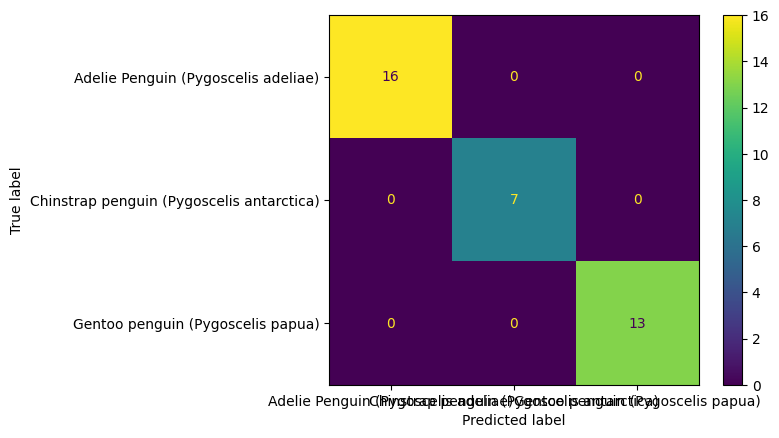

In [58]:
disp = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred_class_test),
    display_labels = class_labels
)
disp.plot()

---
## Register The Model In Vertex AI Model Registry

### Save The Model

Use the [joblib](https://joblib.readthedocs.io/en/stable/) to save the model pipeline to a local folder.

In [72]:
model_filename = os.path.join(DIR, 'model.joblib')

try:
    joblib.dump(model_pipeline, model_filename)
    print(f"Model pipeline saved successfully to: {model_filename}")
except Exception as e:
    print(f"Error saving model pipeline: {e}")

Model pipeline saved successfully to: files/evaluation-classification-multi-class/model.joblib


### Move The Model To GCS

Store the joblib file in GCS for use with the Vertex AI Model Registry.

In [73]:
blob_path = f"{SERIES}/{EXPERIMENT}/model_files"
blob_name = os.path.basename(model_filename)
blob = bucket.blob(os.path.join(blob_path, blob_name))

try:
    blob.upload_from_filename(model_filename, timeout = 600) 
    print(f"Model pipeline uploaded successfully to GCS: gs://{bucket.name}/{blob.name}")
except Exception as e:
    print(f"Error uploading model pipeline to GCS: {e}")

Model pipeline uploaded successfully to GCS: gs://statmike-mlops-349915/mlops/evaluation-classification-multi-class/model_files/model.joblib


### Register The Model

Registering the model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction) requires:
- A GCS URI for the model files
- A Artifact Registry URI to a container than can serve the model files

Vertex AI includes prebuilt containers for [training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) and [serving](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers) including [these](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers#scikit-learn) that are purpose built for Scikit-Learn.  You can alos customize these containers (or your own container) as a [custom prediction container](https://cloud.google.com/vertex-ai/docs/predictions/use-custom-container).  For an example check out this workflow in this repository: [Catboost Custom Prediction With FastAPI](../../Framework%20Workflows/CatBoost/CatBoost%20Custom%20Prediction%20With%20FastAPI.ipynb).

Check for existing version of the model:

In [74]:
parent_model = next(
    (model for model in aiplatform.Model.list(filter=f'display_name="{SERIES}-{EXPERIMENT}"')),
    None # Default value if no model/version is found
)
parent_model

Upload the model to the registry as a new version which will be version 1 if no prior version was found:

In [75]:
vertex_model = aiplatform.Model.upload(
    display_name = SERIES+'-'+EXPERIMENT,
    model_id = SERIES+'-'+EXPERIMENT,
    parent_model = parent_model,
    serving_container_image_uri = 'us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-5:latest',
    artifact_uri = f'gs://{bucket.name}/{blob_path}',
    is_default_version = True,
    labels = {'series': SERIES, 'experiment': EXPERIMENT}
)

Creating Model
Create Model backing LRO: projects/1026793852137/locations/us-central1/models/mlops-evaluation-classification-multi-class/operations/1698452273266425856
Model created. Resource name: projects/1026793852137/locations/us-central1/models/mlops-evaluation-classification-multi-class@1
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/mlops-evaluation-classification-multi-class@1')


---
## Load Model Evaluations To The Vertex AI Model Registry

The versioned models in Vertex AI Model Registry can include evaluations.  Evaluation can even be vizualized and compared directly in the console.  

The model registry, and Vertex AI SDK, include model evaluations as a service where managed jobs can be used to calculate predictions and automatically laod evaluation metrics based on the model type (regression, classification, or forecasting). Read more about [Model evaluation in Vertex AI](https://cloud.google.com/vertex-ai/docs/evaluation/introduction).

In this workflow the evaluation will be manually uploaded with the Vertex AI SDK after first being prepared locally.  The evaluation need to be prepared in the format of one of the schems provided [here](https://console.cloud.google.com/storage/browser/google-cloud-aiplatform/schema/modelevaluation).

This part of the workflow will demonstrate preparing the full set of evaluation metrics for the model above on each split of the data and then loading in the versioned model in the model registry.  The evaluation will then be shown in the console, and retrieved with the SDK.


### Structured Evaluation

First, prepare the evaluations for the model in the structure of the provided schema `google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml` found in the GCS location that is publically available here: [google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml](https://console.cloud.google.com/storage/browser/google-cloud-aiplatform/schema/modelevaluation).

In this example the complete schema is used but it is possible to provide a limited subset.

In [ ]:
labels_to_int_map = {label: i for i, label in enumerate(class_labels)}
y_test_int_encoded = np.array([labels_to_int_map[label] for label in y_test])
y_test_one_hot = np.eye(len(class_labels))[y_test_int_encoded]

test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred_class_test)
print(f"Accuracy (TEST): {test_accuracy:.4f}")

test_prc_auc = sklearn.metrics.average_precision_score(y_test_one_hot, y_pred_proba_test, average='micro')
print(f"PRC AUC (TEST): {test_prc_auc:.4f}")

test_roc_auc = sklearn.metrics.roc_auc_score(y_test_one_hot, y_pred_proba_test, average='micro', multi_class='ovr')
print(f"ROC AUC (TEST): {test_roc_auc:.4f}")

test_log_loss = sklearn.metrics.log_loss(y_test_one_hot, y_pred_proba_test)
print(f"Log Loss (TEST): {test_log_loss:.4f}")

In [92]:
class_labels = model_pipeline.named_steps['classifier'].classes_.tolist()
n_classes = len(class_labels)
labels_to_int_map = {label: i for i, label in enumerate(class_labels)}
class_labels_numerical = list(labels_to_int_map.values())
class_display_names = [f"{labels_to_int_map[label]} ({label})" for label in class_labels]

evaluations = {}

data_splits = {
    'TRAIN': (X_train, y_train),
    'VALIDATE': (X_val, y_val),
    'TEST': (X_test, y_test)
}

In [93]:
for split_name, (X_split, y_split) in data_splits.items():
    # encode y (string labels to integer and one-hot)
    y_split_int_encoded = np.array([labels_to_int_map[label] for label in y_split])
    y_split_one_hot = np.eye(n_classes)[y_split_int_encoded] # Use n_classes for dimension
    # predictions
    y_pred_proba = model_pipeline.predict_proba(X_split)
    y_pred_class_default_threshold = np.argmax(y_pred_proba, axis = 1)
    # overall metrics
    au_prc_val = sklearn.metrics.average_precision_score(y_split_one_hot, y_pred_proba, average = 'weighted')
    au_roc_val = sklearn.metrics.roc_auc_score(y_split_one_hot, y_pred_proba, multi_class='ovr', average='weighted')
    log_loss_val = sklearn.metrics.log_loss(y_split_one_hot, y_pred_proba)
    # overall confusion matrix
    overall_conf_matrix = sklearn.metrics.confusion_matrix(y_split_int_encoded, y_pred_class_default_threshold, labels=class_labels_numerical) # Use numerical labels here
    # confidence metrics for splits
    max_pred_proba = np.max(y_pred_proba, axis = 1)
    confidence_thresholds = (
        list(np.arange(0.0, 1.0, 0.05)) +
        list(np.arange(0.95, 1.0, 0.01))
    )
    confidence_thresholds = sorted(list(set([round(t, 2) for t in confidence_thresholds])))
    confidence_metrics_list = []
    for threshold in confidence_thresholds:
    # {'f1ScoreAt1': 1.0,
    # 'precision': 0.99910367,
    # 'recallAt1': 1.0,
    # 'truePositiveCount': '3344',
    # 'recall': 1.0,
    # 'trueNegativeCount': '50157',
    # 'confidenceThreshold': 0.01,
    # 'falsePositiveRate': 5.980861e-05,
    # 'precisionAt1': 1.0,
    # 'falsePositiveCount': '3',
    # 'f1Score': 0.99955165},

        confident_indices = np.where(max_pred_proba >= threshold)[0]
        if len(confident_indices) == 0:
            recall_val = 0.0
            precision_val = 0.0
            f1_score_micro_val = 0.0 # Corrected from tuple (0.0,) to 0.0
            f1_score_macro_val = 0.0
            false_positive_rate_val = 0.0
            tp_total, fp_total, fn_total, tn_total = 0, 0, 0, 0
        else:
            # Crucially, here we use the original integer y_split and predicted classes
            y_true_confident_int = y_split_int_encoded[confident_indices]
            y_pred_confident_class = y_pred_class_default_threshold[confident_indices]

            # Calculate metrics for the subset of confident predictions
            recall_val = sklearn.metrics.recall_score(y_true_confident_int, y_pred_confident_class, average='weighted', zero_division=0)
            precision_val = sklearn.metrics.precision_score(y_true_confident_int, y_pred_confident_class, average='weighted', zero_division=0)
            f1_score_micro_val = sklearn.metrics.f1_score(y_true_confident_int, y_pred_confident_class, average='micro', zero_division=0)
            f1_score_macro_val = sklearn.metrics.f1_score(y_true_confident_int, y_pred_confident_class, average='macro', zero_division=0)

            # Confusion matrix is no longer outputted per threshold, but used for counts
            conf_matrix_confident = sklearn.metrics.confusion_matrix(
                y_true_confident_int,
                y_pred_confident_class,
                labels = class_labels_numerical # Use numerical labels for matrix calculation
            )
            tp_total = int(np.trace(conf_matrix_confident))
            total_confident_instances = len(y_true_confident_int)
            fp_total = int(total_confident_instances - tp_total) # Total incorrect predictions
            fn_total = int(total_confident_instances - tp_total) # Same as fp_total in this overall context
            false_positive_rate_val = 0. # Placeholder for multi-class
            tn_total = 0 # Placeholder for multi-class

        confidence_metrics_entry = {
            'confidenceThreshold': threshold,
            #'maxPredictions': 2147483647, # As per schema
            'recall': recall_val,
            'precision': precision_val,
            'falsePositiveRate': false_positive_rate_val,
            'f1Score': f1_score_micro_val,
            'recallAt1': recall_val,
            'precisionAt1': precision_val,
            'f1scoreMicro': f1_score_micro_val, # Explicitly included
            'f1scoreMacro': f1_score_macro_val, # Explicitly included
            'truePositiveCount': int(tp_total),
            'falsePositiveCount': int(fp_total),
            'falseNegativeCount': int(fn_total),
            'trueNegativeCount': int(tn_total), # Ensure it's an int
            }

        confidence_metrics_list.append(confidence_metrics_entry)
    evaluations[split_name] = {
        'auPrc': au_prc_val,
        'auRoc': au_roc_val,
        'logLoss': log_loss_val,
        'confidenceMetrics': confidence_metrics_list,
        'confusionMatrix': { # Overall confusion matrix at default 0.5 threshold
            'annotationSpecs': [{'id': str(label), 'displayName': display_name}
                                for label, display_name in zip(class_labels_numerical, class_display_names)], # Use numerical labels for 'id'
            'rows': [{'dataItemCounts': row.tolist()} for row in overall_conf_matrix]
        }
    }

Review the metrics for the first threshold of the 'TRAIN' split:

In [ ]:
evaluations['TRAIN']['confidenceMetrics'][0]

{'confidenceThreshold': np.float64(0.0),
 'recall': 1.0,
 'precision': 1.0,
 'falsePositiveRate': 0.0,
 'f1Score': 1.0,
 'recallAt1': 1.0,
 'precisionAt1': 1.0,
 'f1scoreMicro': 1.0,
 'f1scoreMacro': 1.0,
 'truePositiveCount': 274,
 'falsePositiveCount': 0,
 'falseNegativeCount': 0,
 'trueNegativeCount': 0}

### Load The Evaluations

Use the [ModelServiceClient](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.model_service) to load the evaluation metrics with the [import_model_evaluation](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.model_service.ModelServiceClient#google_cloud_aiplatform_v1_services_model_service_ModelServiceClient_import_model_evaluation) method.

In [95]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {'api_endpoint': f"{REGION}-aiplatform.googleapis.com"}
)

In [96]:
for eval in evaluations:
    eval_upload = model_client.import_model_evaluation(
        parent = vertex_model.versioned_resource_name,
        model_evaluation = aiplatform.gapic.ModelEvaluation(
            display_name = f'training-{eval.lower()}',
            metrics_schema_uri = 'gs://google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml',
            metrics = evaluations[eval]
        )
    )

InvalidArgument: 400 Invalid Metrics format.

### Review Evaluation In The Vertex AI Console

See a list of evaluations for a model+version in the Vertex AI Model Registry:
<div style="text-align: center;"><img src="../resources/images/screenshots/evaluation/class-binary/registry_evaluations.png" style="border: 2px solid black; width: auto; height: 600px;"></div>

Review an evaluation, including changing the confidence threshold:
<div style="text-align: center;"><img src="../resources/images/screenshots/evaluation/class-binary/registry_evaluation_review.gif" style="border: 2px solid black; width: auto; height: 600px;"></div>

Compare evaluations side-by-side:
<div style="text-align: center;"><img src="../resources/images/screenshots/evaluation/class-binary/registry_evaluation_compare.gif" style="border: 2px solid black; width: auto; height: 600px;"></div>


In [ ]:
vertex_model.get_model_evaluation(evaluation_id = eval_upload.name.split('/')[-1])

resource name: projects/1026793852137/locations/us-central1/models/mlops-evaluation-classification-binary@1/evaluations/166787763710858184

# TESTING

In [90]:
model_name = 'projects/1026793852137/locations/us-central1/models/4624672350263050240@1'
eval_name = '3167412446436289219'

In [88]:
aiplatform.Model(model_name = model_name)

resource name: projects/1026793852137/locations/us-central1/models/4624672350263050240

In [89]:
ex_model = aiplatform.Model(model_name = model_name)

In [91]:
ex_model_eval = ex_model.get_model_evaluation(evaluation_id = eval_name)
ex_model_eval.to_dict()

{'name': 'projects/1026793852137/locations/us-central1/models/4624672350263050240@1/evaluations/3167412446436289219',
 'metricsSchemaUri': 'gs://google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml',
 'metrics': {'auPrc': 1.0,
  'auRoc': 0.99999994,
  'logLoss': 0.000155824,
  'confusionMatrix': {'rows': [[1058.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0],
    [0.0,
     721.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0],
    [0.0,
     0.0,
     587.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0],
    [0.0,
     0.0,
     0.0,
     187.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0,
     0.0],
    [0.0,
     0

In [92]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {'api_endpoint': f"{REGION}-aiplatform.googleapis.com"}
)

In [93]:
ex_model_eval_2 = model_client.get_model_evaluation(name = ex_model_eval.resource_name)
ex_model_eval_2

name: "projects/1026793852137/locations/us-central1/models/4624672350263050240@1/evaluations/3167412446436289219"
display_name: "AutoML Tabular"
metrics_schema_uri: "gs://google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml"
metrics {
  struct_value {
    fields {
      key: "logLoss"
      value {
        number_value: 0.000155824
      }
    }
    fields {
      key: "confusionMatrix"
      value {
        struct_value {
          fields {
            key: "rows"
            value {
              list_value {
                values {
                  list_value {
                    values {
                      number_value: 1058
                    }
                    values {
                      number_value: 0
                    }
                    values {
                      number_value: 0
                    }
                    values {
                      number_value: 0
                    }
                    values {
           

In [94]:
dict(ex_model_eval_2.metrics)

{'auPrc': 1.0,
 'auRoc': 0.99999994,
 'logLoss': 0.000155824,
 'confusionMatrix': <proto.marshal.collections.maps.MapComposite at 0x7fc1b4a345c0>,
 'confidenceMetrics': [<proto.marshal.collections.maps.MapComposite object at 0x7fc1b4683710>, <proto.marshal.collections.maps.MapComposite object at 0x7fc1b468af60>, <proto.marshal.collections.maps.MapComposite object at 0x7fc1b468a720>, <proto.marshal.collections.maps.MapComposite object at 0x7fc1b468bc20>, <proto.marshal.collections.maps.MapComposite object at 0x7fc1b468be60>, <proto.marshal.collections.maps.MapComposite object at 0x7fc1b468bf80>, <proto.marshal.collections.maps.MapComposite object at 0x7fc1b468b860>, <proto.marshal.collections.maps.MapComposite object at 0x7fc1b468a810>, <proto.marshal.collections.maps.MapComposite object at 0x7fc1b46883b0>, <proto.marshal.collections.maps.MapComposite object at 0x7fc1b4a23e30>, <proto.marshal.collections.maps.MapComposite object at 0x7fc1b4a23ec0>, <proto.marshal.collections.maps.MapCom

In [95]:
ex_model_eval_2.model_explanation

mean_attributions {
  feature_attributions {
    struct_value {
      fields {
        key: "workclass"
        value {
          number_value: 2.4302161128094455e-06
        }
      }
      fields {
        key: "sex"
        value {
          number_value: 1.0131074457783755e-06
        }
      }
      fields {
        key: "relationship"
        value {
          number_value: 3.3945976828375071e-06
        }
      }
      fields {
        key: "race"
        value {
          number_value: 1.6551600975056004e-06
        }
      }
      fields {
        key: "occupation"
        value {
          number_value: 6.9770570426790861e-06
        }
      }
      fields {
        key: "native_country"
        value {
          number_value: 8.6872308559519543e-06
        }
      }
      fields {
        key: "marital_status"
        value {
          number_value: 2.0518765744461739e-06
        }
      }
      fields {
        key: "income_bracket"
        value {
          number_value: 1

In [82]:
model_client.list_model_evaluation_slices(parent = ex_model_eval.resource_name)

ListModelEvaluationSlicesPager<model_evaluation_slices {
  name: "projects/1026793852137/locations/us-central1/models/2417908532851507200/evaluations/7129073382751037905/slices/1282113823966867312"
  slice_ {
    dimension: "annotationSpec"
    value: " >50K"
  }
  metrics_schema_uri: "gs://google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml"
  metrics {
    struct_value {
      fields {
        key: "logLoss"
        value {
          number_value: 0.279572
        }
      }
      fields {
        key: "confidenceMetrics"
        value {
          list_value {
            values {
              struct_value {
                fields {
                  key: "truePositiveCount"
                  value {
                    string_value: "846"
                  }
                }
                fields {
                  key: "recall"
                  value {
                    number_value: 1
                  }
                }
                fields {